In [2]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [3]:
train = pd.read_parquet('../data/processed/train.parquet')
test = pd.read_parquet('../data/processed/test.parquet')

scaler = joblib.load('../models/scaler.joblib')



In [4]:
X_train = train.drop('target', axis=1)
X_train = X_train.drop(columns=['date']) 
X_train = X_train.drop(columns=['season']) 
y_train = train['target']
X_test = test.drop('target', axis=1)
X_test = X_test.drop(columns=['date']) 
X_test = X_test.drop(columns=['season']) 
y_test = test['target']

In [11]:
y_test.head()

47   -0.666667
48   -0.444444
49   -0.222222
50   -0.311111
51    0.000000
Name: target, dtype: float64

In [6]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
print(f"MAE Baseline: {mae(y_test, baseline.predict(X_test)):.2f}")

MAE Baseline: 0.47


In [7]:
X_train = X_train.drop(columns=['date']) if 'date' in X_train.columns else X_train

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train,
                          cv=TimeSeriesSplit(n_splits=5),
                          scoring='neg_mean_absolute_error')
print(f"RF MAE Médio: {-rf_scores.mean():.2f}")

RF MAE Médio: 0.75


In [8]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

grid = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid.best_params_}")

Melhores parâmetros: {'max_depth': 5, 'n_estimators': 200}


Text(0, 0.5, 'Predito')

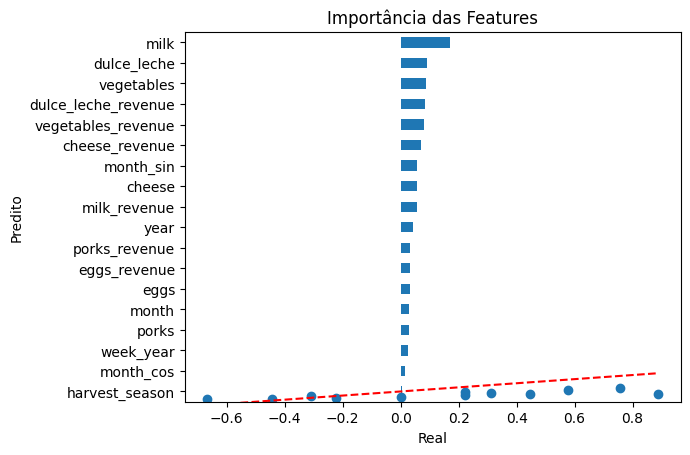

In [9]:
# Feature Importance
pd.Series(grid.best_estimator_.feature_importances_,
          index=X_train.columns).sort_values().plot.barh()
plt.title('Importância das Features');

# Predições vs Real
plt.scatter(y_test, grid.predict(X_test))
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Predito')

In [10]:
joblib.dump(grid.best_estimator_, '../models/best_model.joblib')

['../models/best_model.joblib']